In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import CompPhy as cp

plt.style.use("custom.matplotlibrc")

# Implementation of Exact Results

1 / J       m          e   
 0.25   1.0000000   -8.000 
 1.0    0.9992758   -1.997 
 2.0    0.9113194   -0.873 
 3.0    0.0000000   -0.272 


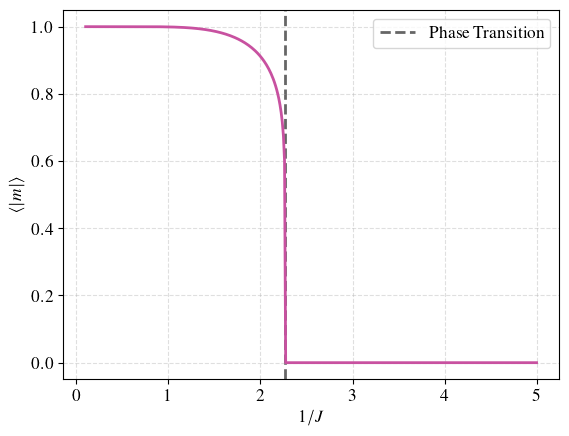

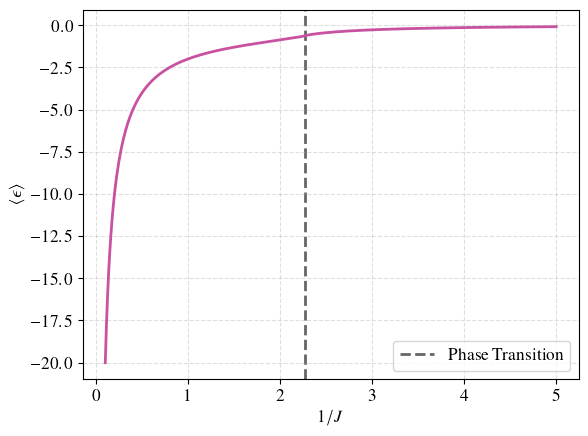

In [10]:
J_c = 0.5 * np.log(1 + np.sqrt(2))


@np.vectorize
def mean_mag_per_site(J):

    if J <= J_c:
        return 0

    return np.power(1 - 1 / np.sinh(2 * J) ** 4, 0.125)


def mean_energy_per_site(J):
    tanh2 = np.tanh(2 * J) ** 2
    fac = -J * np.cosh(2 * J) / np.sinh(2 * J)
    term1 = 2 * tanh2 - 1
    term2 = scipy.special.ellipk(4 * (1 - tanh2) * tanh2)

    return fac * (1 + 2 / np.pi * term1 * term2)


# Proof that it works
print("{:^6}".format("1 / J"), "{:^12}".format("m"), "{:^7}".format("e"))
for J in [4, 1, 0.5, 1 / 3]:
    j = "{:^6}".format(1 / J)
    m = "{:^12.7f}".format(mean_mag_per_site(J))
    e = "{:^7.3f}".format(mean_energy_per_site(J))
    print(j, m, e)

var = np.linspace(0.1, 5, 400)

# mag per site
plt.figure(0)
plt.plot(var, mean_mag_per_site(1 / var), linewidth=2)
plt.xlabel(r"$1 / J$")
plt.ylabel(r"$\expval{\abs{m}}$")
plt.grid(alpha=0.4, linestyle="--")
plt.axvline(
    1 / J_c,
    label="Phase Transition",
    color="black",
    linestyle="--",
    alpha=0.6,
    linewidth=2,
    zorder=0,
)
plt.legend()
plt.savefig(r"Exercise_5/mean_mag_per_site.pdf")

# e per site
plt.figure(1)
plt.plot(var, mean_energy_per_site(1 / var), linewidth=2)
plt.xlabel(r"$1 / J$")
plt.ylabel(r"$\expval{\epsilon}$")
plt.grid(alpha=0.4, linestyle="--")
plt.axvline(
    1 / J_c,
    label="Phase Transition",
    color="black",
    linestyle="--",
    alpha=0.6,
    linewidth=2,
    zorder=0,
)
plt.legend()
plt.savefig(r"Exercise_5/mean_energy_per_site.pdf")

# MCMC in 2D

## Generate Ensembles and Cutting off Burn in

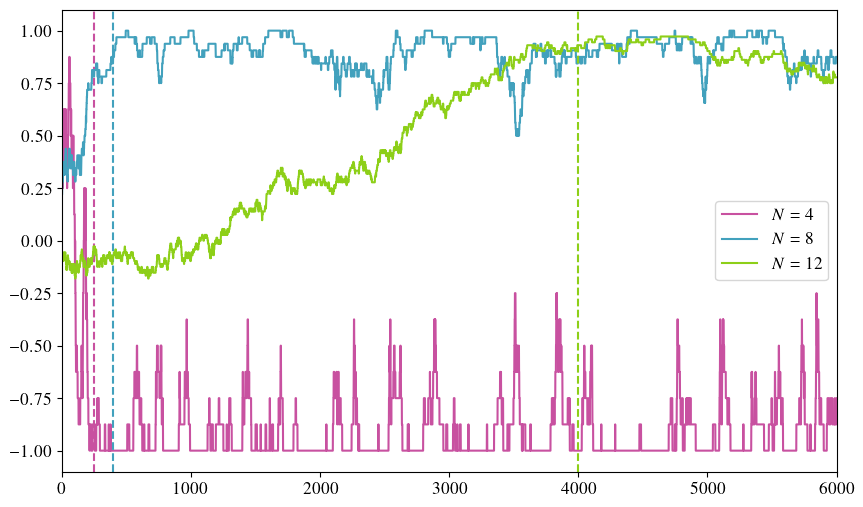

In [41]:
from CompPhy.mcmc import Ising2D
from CompPhy.autocorrelation import normalized_autocorrelation

np.random.seed(1)

plt.style.use("custom.matplotlibrc")


plt.figure(0, figsize=(10, 6))
burn_in = [250, 400, 4000]

for b, n in zip(burn_in, [4, 8, 12]):
    model = Ising2D(J=0.5, h=0, lattice_sites=n)
    config_name = f"Exercise_5/ensemble_{n}"
    
    number_of_configs = pow(10, 5)
    t = range(number_of_configs)
    configs = model(number_of_configs)

    m = configs.mean(axis=(1, 2))
    plt.xlim((0, 6000))
    t = list(range(len(m)))
    p = plt.plot(t, m, label=f"$N = {n}$")
    plt.axvline(t[b], color=p[0].get_color(), linestyle="--")
    
    configs = configs[b:]
    np.save(config_name, configs)


plt.legend()
plt.savefig("Exercise_5/burn_in.pdf")

In [ ]:
from CompPhy.mcmc import Ising2D
from CompPhy.autocorrelation import normalized_autocorrelation

np.random.seed(0)

plt.style.use("custom.matplotlibrc")


plt.figure(0, figsize=(10, 6))
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))

for n in [4, 8, 12]:
    # model = Ising2D(J=0.5, h=0, lattice_sites=n)
    config_name = f"Exercise_5/ensemble_{n}"
    
    # number_of_configs = pow(10, 5)
    # t = range(number_of_configs)
    # configs = model(number_of_configs)
    # np.save(config_name, configs)
    configs = np.load(config_name + ".npy")
    
    # Plot m
    m = configs.mean(axis=(1, 2))
    np.save(f"{config_name}_m.npy", m)
    plt.figure(0)
    plt.plot(t, m, label=f"$N = {{{n}}}$")
    # plt.xscale("log")
    plt.xlabel("$t$")
    plt.ylabel("$m$")
   
    # Plot |m| 
    plt.figure(1)
    plt.plot(t, abs(m), label=f"$N = {{{n}}}$")
    # plt.xscale("log")
    plt.xlabel("$t$")
    plt.ylabel(r"$\abs{m}$")
    
    # Plot e 
    plt.figure(2)
    e = model._calc_h(configs) / n**2
    np.save(config_name + "_e", e)
    plt.plot(t, e, label=f"$N = {{{n}}}$")
    plt.ylabel("$\\epsilon$")
    plt.xlabel("$t$")
    # plt.xscale("log")
    
    plt.figure(3)

plt.figure(0)
plt.legend()
plt.savefig("Exercise_5/mcmc_m.pdf")
plt.figure(1)
plt.legend()
plt.savefig("Exercise_5/mcmc_abs_m.pdf")
plt.figure(2)
plt.savefig("Exercise_5/mcmc_e.pdf")
plt.legend()
    
    

FileNotFoundError: [Errno 2] No such file or directory: 'Exercise_5/ensemble_4'

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## integrated autocorrelation time 

In [12]:
import numpy as np

m = {n: np.load(f"Exercise_5/ensemble_{n}_m.npy") for n in [4, 8, 12]}
e = {n: np.load(f"Exercise_5/ensemble_{n}_e.npy") for n in [4, 8, 12]}

In [13]:
from CompPhy.autocorrelation import integrated_autocorrelation

for n, mag in m.items():
    tau_m = integrated_autocorrelation(mag)
    print(f"n: {n}, tau_m: {tau_m}")
for n, ev in e.items():
    tau_e = integrated_autocorrelation(ev)
    print(f"n: {n}, tau_e: {tau_e}")

n: 4, tau_m: 1610.4535475924763
n: 8, tau_m: 274.8706246170642
n: 12, tau_m: 2208.5007106160906
n: 4, tau_e: 38.388303638499025
n: 8, tau_e: 380.46169388987363
n: 12, tau_e: 9080.771740275946
